# Example: Gaussian with Given Variance

As a model we are given a univariate Gaussian distribution with unknown mean
and standard deviation σ = 1. We have one data point at 2.0. For this
toy example, we can compute the posterior over the mean. But to illustrate
likelihood-free inference, let us assume here that we can only sample from the
model:

In [1]:
using LikelihoodfreeInference, Distributions, Random
model(x) = randn() .+ x

model (generic function with 1 method)

LikelihoodfreeInference.jl passes parameter values as vectors to the model,
even in the one-dimensional case. In our definition of the model we assume
that `x[1]` is the mean.

## Approximate the Posterior
Our first goal is to find the posterior over the mean given observation and
a Gaussian prior with mean 0 and standard deviation 5.

In [2]:
data = [2.0]
prior = MultivariateNormal([0.], [5.])

DiagNormal(
dim: 1
μ: [0.0]
Σ: [25.0]
)


The true posterior is a Gaussian distribution with mean 25/26*2 and standard
deviation 26/25

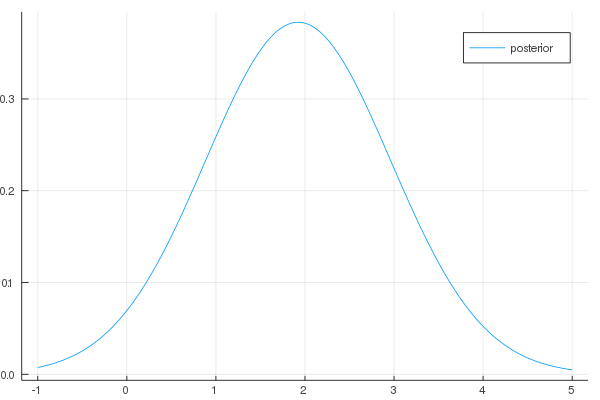

In [3]:
trueposterior = pdf.(Normal.(-1:.01:5, 26/25), 25/26*2.0)
using Plots
gr()
figure = plot(-1:.01:5, trueposterior, label = "posterior")

Now, we will use an adaptive sequential Monte Carlo method:

In [4]:
smc = AdaptiveSMC(prior = prior, K = 10^4)
result = run!(smc, model, data, verbose = true, maxfevals = 10^6);

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1      1 second    19000 8.957060e+00 0.8999999999999997
         2      1 second    27101 7.137315e+00 0.8101000000000007
         3      1 second    34392 5.973385e+00 0.7291000000000006
         4      1 second    40954 5.136284e+00 0.6561999999999998
         5      1 second    46860 4.488039e+00   0.5906
         6      1 second    52176 3.933274e+00   0.5316
Resampling...
         7     2 seconds    62176 3.496501e+00 0.9999999999999998
         8     2 seconds    71176 3.125901e+00 0.8999999999999998
         9     2 seconds    79277 2.779721e+00 0.8101000000000007
        10     2 seconds    86568 2.498010e+00 0.7291000000000007
        11     2 seconds    93130 2.234993e+00 0.6561999999999997
        12     2 seconds    99036 1.996992e+00 0.5906000000000001
        13     2 seconds   104352 1.797728e+00   0.5316
Resampling...
        14     2 seconds   114352 1.6213

As a Monte Carlo Method the result is a list of particles

In [5]:
particles(smc)

10000-element Array{Array{Float64,1},1}:
 [3.34592128200567]
 [0.9752406132630753]
 [0.2175629838991523]
 [0.08382310758877348]
 [1.3946355443498226]
 [2.4541810294739212]
 [2.139965578539247]
 [2.0200025181488366]
 [1.334322456196738]
 [2.3473334958282193]
 ⋮
 [4.562235629042836]
 [2.8747264564321346]
 [1.5593774749572438]
 [0.7850833315943027]
 [2.269336709049081]
 [2.7543571869694086]
 [1.1544965348496319]
 [3.338738931125596]
 [3.171801637915493]

with corresponding weights

In [6]:
weights(smc)

10000-element Array{Float64,1}:
 0.0
 0.0
 0.00018331805682859762
 0.00018331805682859762
 0.00018331805682859762
 0.00018331805682859762
 0.00018331805682859762
 0.00018331805682859762
 0.0
 0.00018331805682859762
 ⋮
 0.00018331805682859762
 0.00018331805682859762
 0.0
 0.00018331805682859762
 0.00018331805682859762
 0.0
 0.00018331805682859762
 0.00018331805682859762
 0.0

The mean of the posterior is given by `weights(smc) .* particles(smc)`, which
is computed by the `mean` function.

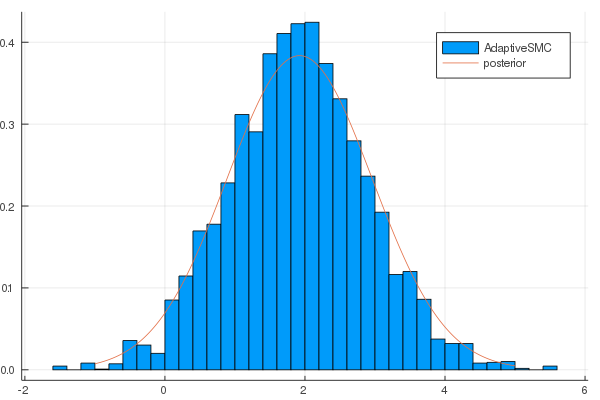

In [7]:
mean(smc)

figure = histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

The `result` above also contains these weights and particles and some
additional information.

In [8]:
keys(result)

(:weights, :particles, :n_sims, :epsilons)

AdaptiveSMC reduced the epsilon parameter adaptively, as we saw in column
epsilon of the run above. We can plot this sequence.

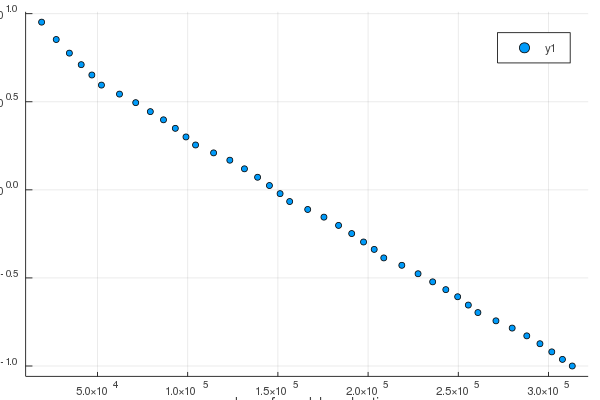

In [9]:
scatter(cumsum(result.n_sims)[2:end], result.epsilons,
        yscale = :log10, ylabel = "epsilon", xlabel = "number of model evaluations")

Alternatively, we may want to use KernelABC.

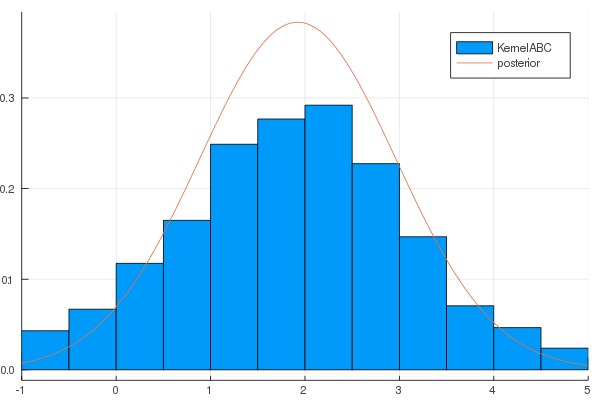

In [10]:
kabc = KernelABC(prior = prior,
                 kernel = Kernel(),
                 delta = 1e-12,
                 K = 10^4)
result = run!(kabc, model, data, maxfevals = 10^4)
mean(kabc)

figure = histogram(vcat(particles(kabc)...), weights = weights(kabc),
                   xlims = (-1, 5), bins = 100,
                   normalize = true, label = "KernelABC")
plot!(figure, -1:.01:5, trueposterior, label = "posterior")

## Point Estimates
Sometimes we just want a point estimate. We will use BayesianOptimization.jl
here to minimize the default `QDLoss`. We know that the true maximum
likelihood estimate is at mean = 25/26*2 ≈ 1.923

In [11]:
using BayesianOptimization
p = PointEstimator(optimizer = bo([-10.], [10.]), prior = prior, K = 100)
result = run!(p, model, data, maxfevals = 5*10^4, verbose = false);
result.x

1-element Array{Float64,1}:
 1.943096191783218

KernelRecursiveABC is an alternative method that requires often only few model
evaluations in low and medium dimensional problems

In [12]:
k = KernelRecursiveABC(prior = prior,
                       kernel = Kernel(),
                       kernelx = Kernel(),
                       delta = 1e-2,
                       K = 100)
result = run!(k, model, data, maxfevals = 2*10^3)
result.x

iteration         elapsed     fevals
        1       0 seconds        100
        2       2 seconds        200
        3       3 seconds        300
        4       3 seconds        400
        5       4 seconds        500
        6       5 seconds        600
        7       5 seconds        700
        8       6 seconds        800
        9       6 seconds        900
       10       7 seconds       1000
       11       7 seconds       1100
       12       8 seconds       1200
       13       8 seconds       1300
       14       9 seconds       1400
       15      10 seconds       1500
       16      10 seconds       1600
       17      11 seconds       1700
       18      11 seconds       1800
       19      12 seconds       1900
       20      12 seconds       2000


1-element Array{Float64,1}:
 1.956747144161939

## iid Samples
Let us suppose here that the data consists of multiple independent and
identically distributed samples.

In [13]:
data_iid = [[2.0], [1.9], [2.8], [2.1]]

4-element Array{Array{Float64,1},1}:
 [2.0]
 [1.9]
 [2.8]
 [2.1]

There are two ways to deal with this data. Either we just assume it is one
four-dimensional vector

In [14]:
data_onevec = vcat(data_iid...)

4-element Array{Float64,1}:
 2.0
 1.9
 2.8
 2.1

and we define the model as

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1     0 seconds    19000 1.836893e+01 0.8999999999999997
         2     0 seconds    27101 1.463949e+01 0.8101000000000007
         3     0 seconds    34392 1.234003e+01 0.7291000000000006
         4      1 second    40954 1.067694e+01 0.6561999999999998
         5      1 second    46860 9.408457e+00   0.5906
         6      1 second    52176 8.300895e+00   0.5316
Resampling...
         7      1 second    62176 7.370859e+00 0.9999999999999998
         8      1 second    71176 6.592129e+00 0.8999999999999997
         9      1 second    79277 5.946166e+00 0.8101000000000007
        10      1 second    86568 5.385991e+00 0.7291000000000006
        11      1 second    93130 4.870268e+00 0.6561999999999998
        12      1 second    99036 4.457078e+00   0.5906
        13     2 seconds   104352 4.103349e+00   0.5316
Resampling...
        14     2 seconds   114352 3.790737e+00 0.9

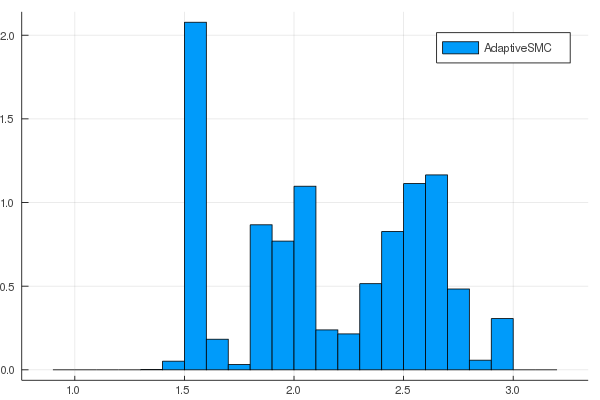

In [15]:
model_iid_onevec(x) = vcat([model(x) for _ in 1:4]...)
smc = AdaptiveSMC(prior = prior, K = 10^4)
result = run!(smc, model_iid_onevec, data_onevec, verbose = true, maxfevals = 10^6);
histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")

Alternatively, we use another distance function:

 iteration       elapsed   fevals  epsilon      ess
         0     0 seconds    10000      Inf        1
         1      1 second    19000 1.682737e+01 0.8999999999999997
         2      1 second    27101 1.322672e+01 0.8101000000000007
         3      1 second    34392 1.086168e+01 0.7291000000000007
         4      1 second    40954 9.147456e+00 0.6561999999999997
         5      1 second    46860 7.894654e+00   0.5906
         6      1 second    52176 6.778792e+00   0.5316
Resampling...
         7     2 seconds    62176 5.835927e+00 0.9999999999999998
         8     2 seconds    71178 5.007300e+00 0.9002000000000002
         9     2 seconds    79280 4.351218e+00 0.8102000000000004
        10     2 seconds    86572 3.744470e+00 0.7291999999999996
        11     2 seconds    93135 3.239866e+00 0.6563000000000002
        12     2 seconds    99042 2.768011e+00 0.5906999999999998
        13     3 seconds   104359 2.380965e+00 0.5317000000000001
Resampling...
        14     3 seconds   114

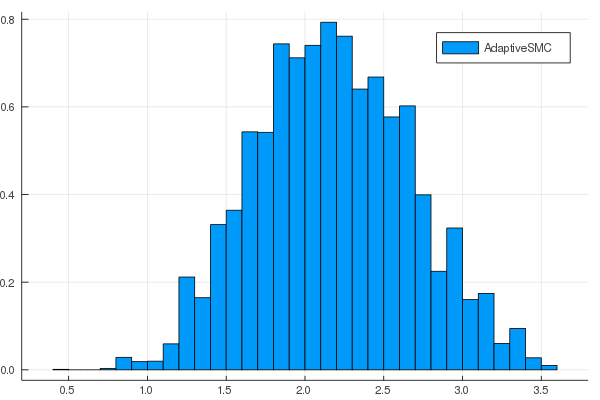

In [16]:
model_iid(x) = [model(x) for _ in 1:4]
smc = AdaptiveSMC(prior = prior, K = 10^4, distance = energydistance)
result = run!(smc, model_iid, data_iid, verbose = true, maxfevals = 10^6);
histogram(vcat(particles(smc)...), weights = weights(smc), normalize = true, label = "AdaptiveSMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*